In [96]:
%matplotlib inline

import pandas as pd
import numpy as np

# Dates
from datetime import datetime
from dateutil import parser

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

**Required for Plotly**

In [ ]:
!pip install jupyterlab "ipywidgets>=7.5"

In [ ]:
!jupyter labextension install jupyterlab-plotly@4.11.0

In [463]:
# Import and update data types
df_timeseries = pd.read_csv("data/timeseries_with_tasks.csv", index_col = None,
                            dtype = {'pid': str,
                                     'episodeid': str,
                                     'providerpracticezipcode': str
                                    }
                           )

date_cols = ["week", "admit_week_start", "discharge_week_start", "admitdate", "dischargedate"]

for _ in date_cols:
    df_timeseries[_] = pd.to_datetime(df_timeseries[_])

In [467]:
# Adding Monthly Aggregation (just in case)
df_timeseries['month'] = pd.to_datetime(df_timeseries['week']) - pd.tseries.offsets.MonthBegin(1)

## Intial Exploration (Overall)

In [257]:
cols_to_keep = ['week', 'episodeid', 'week_admit', 'month', 'pid', 'contracttype', 'county', 'onsite_hours', 'remote_hours']

In [258]:
# Drop columns unlikely to use
df_eda1 = df_timeseries.drop(df_timeseries.columns.difference(cols_to_keep), 
                             axis = 1)

In [118]:
df_group_week = df_eda1.groupby(by=['week']).sum()
df_group_month = df_eda1.groupby(by=['month']).sum()

In [119]:
# Add total_hours column
df_group_week['total_hours'] = df_group_week['onsite_hours'] + df_group_week['remote_hours']
df_group_month['total_hours'] = df_group_month['onsite_hours'] + df_group_month['remote_hours']

In [380]:
df_group_week_tmp = df_eda1.groupby(by=['week', 'county']).sum().reset_index()

In [382]:
df_group_week_tmp = df_group_week_tmp.drop(['week_admit', 'remote_hours'], axis = 1)

In [387]:
df_group_week_tmp = df_group_week_tmp.pivot_table(index=["week"], columns = 'county', values='onsite_hours')

KeyError: 'onsite_hours'

KeyError: "['week'] not in index"

In [389]:
df_tmp = df_group_week_tmp['Harris']

In [393]:
df_tmp

week
2018-12-31    943.84
2019-01-07    432.05
2019-01-14    356.91
2019-01-21    142.23
2019-01-28    704.21
               ...  
2020-02-10      2.43
2020-02-17      1.80
2020-02-24      3.15
2020-03-02       NaN
2020-03-09       NaN
Name: Harris, Length: 63, dtype: float64

In [396]:
fig0 = px.line(df_tmp, 
               x = df_group_week.index.values, 
               y = df_group_week.values)

fig0.show();

ValueError: All arguments should have the same length. The length of argument `wide_variable_0` is 3, whereas the length of  previously-processed arguments ['x'] is 63

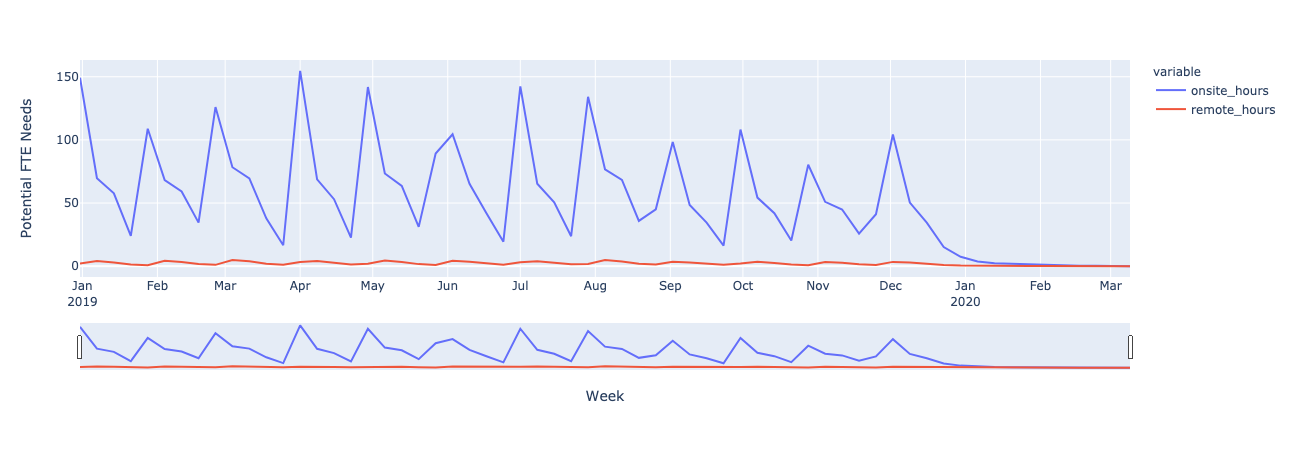

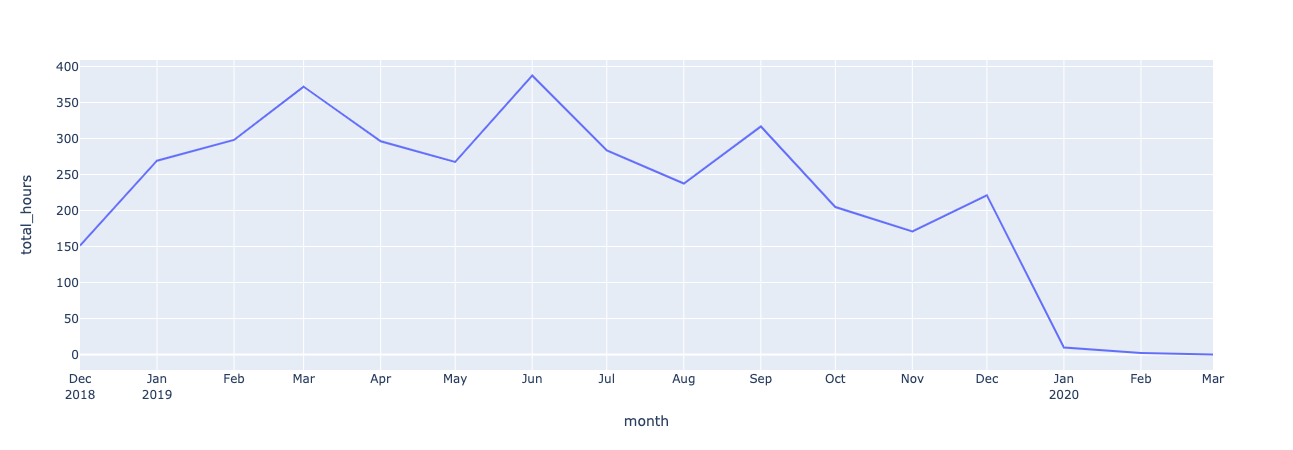

In [325]:
fig0 = px.line(df_group_week / 40, 
               x = df_group_week.index, 
               y = df_group_week.columns[0:2])

fig0.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    rangeslider_visible=True
)

fig0.update_layout(
    xaxis_title = 'Week',
    yaxis_title = 'Potential FTE Needs'
)

fig0.show();


fig1 = px.line(df_group_month / 40, 
              x = df_group_month.index, 
              y = 'total_hours')

fig1.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")

fig1.show();

Smoothing to a rolling 30 days to get a getter picture of overall changes in 'total hours'

Between the above visualizations and these, we see that there is a clear downward trending 'need' for CC's in terms of hours. The next questions we need to figure out will be

* Is this decreasing for a reason (fewer patients, length of stay, contract types, etc.)
* Where is this occuring. Is this across all of Texas or in specific counties?

In [332]:
df_rolling = df_group_week.rolling("30D").sum()

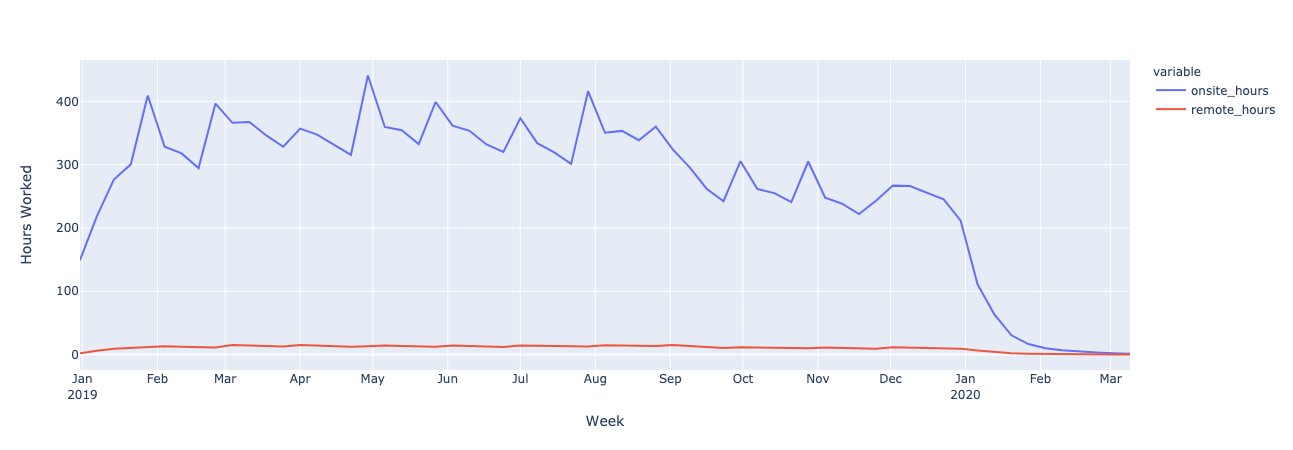

In [333]:
fig0 = px.line(df_rolling / 40, 
               x = df_rolling.index, 
               y = df_rolling.columns[0:2])

fig0.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
#     rangeslider_visible=True
)

fig0.update_layout(
    xaxis_title = 'Week',
    yaxis_title = 'Hours Worked'
)

fig0.show();

Week over Week Difference

In [337]:
df_group_week_diff = df_group_week.diff()

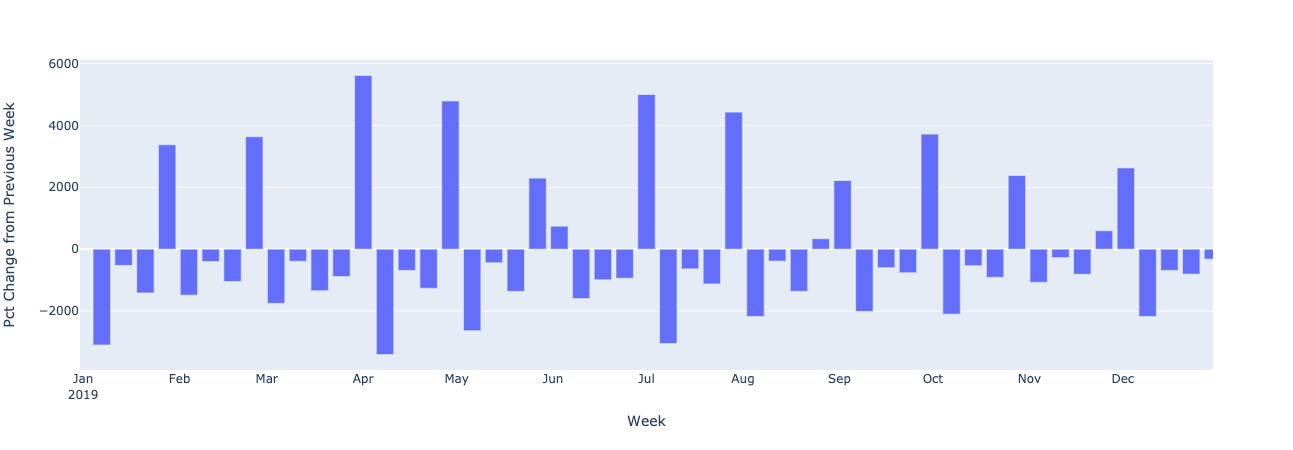

In [338]:
data = df_group_week_diff['total_hours']

fig = px.bar(data, 
             x = data.index, 
             y = data)

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
)

fig.update_layout(
    xaxis_title = 'Week',
    yaxis_title = 'Pct Change from Previous Week',
    xaxis_range = ['2018-12-31','2019-12-30'],
    barmode='relative'
)

fig.show();

## Why -- Looking at why there is a drop in CC on-site needs
---

### Patient Volume

In [270]:
df_timeseries.head()

,week,pid,episodeid,contracttype,county,providerpracticezipcode,admit_week_start,discharge_week_start,first_week_regular,len_of_stay,...,week_admit,week_discharge,regular_time,discharge_time,admit_time,remote_time,onsite_time,onsite_hours,remote_hours,month
0,2018-12-31,6,17500,CT2,Brazos,77845,2018-12-31,2019-01-14,3,17,...,1,0,20.344286,0.0,81.82,1.29,102.16,1.7,0.02,2018-12-01
1,2018-12-31,6,17793,CT2,Brazos,77845,2018-12-31,2019-01-14,3,16,...,1,0,20.344286,0.0,81.82,1.29,102.16,1.7,0.02,2018-12-01
2,2018-12-31,6,18516,CT2,Brazos,77845,2018-12-31,2019-01-28,3,30,...,1,0,20.344286,0.0,81.82,1.29,102.16,1.7,0.02,2018-12-01
3,2018-12-31,6,19016,CT2,Brazos,77845,2018-12-31,2019-01-14,3,15,...,1,0,20.344286,0.0,81.82,1.29,102.16,1.7,0.02,2018-12-01
4,2018-12-31,6,19129,CT2,Brazos,77845,2018-12-31,2019-01-07,3,7,...,1,0,20.344286,0.0,81.82,1.29,102.16,1.7,0.02,2018-12-01


In [339]:
data = df_eda1.loc[df_eda1['week_admit'] == 1, ['month', 'week_admit']]

In [343]:
data = data.groupby(by=['month']).agg('sum').reset_index()

In [344]:
data

,month,week_admit
0,2018-12-01,3871
1,2019-01-01,3306
2,2019-02-01,3693
3,2019-03-01,3523
4,2019-04-01,3607
5,2019-05-01,3673
6,2019-06-01,3250
7,2019-07-01,3727
8,2019-08-01,2716
9,2019-09-01,2737


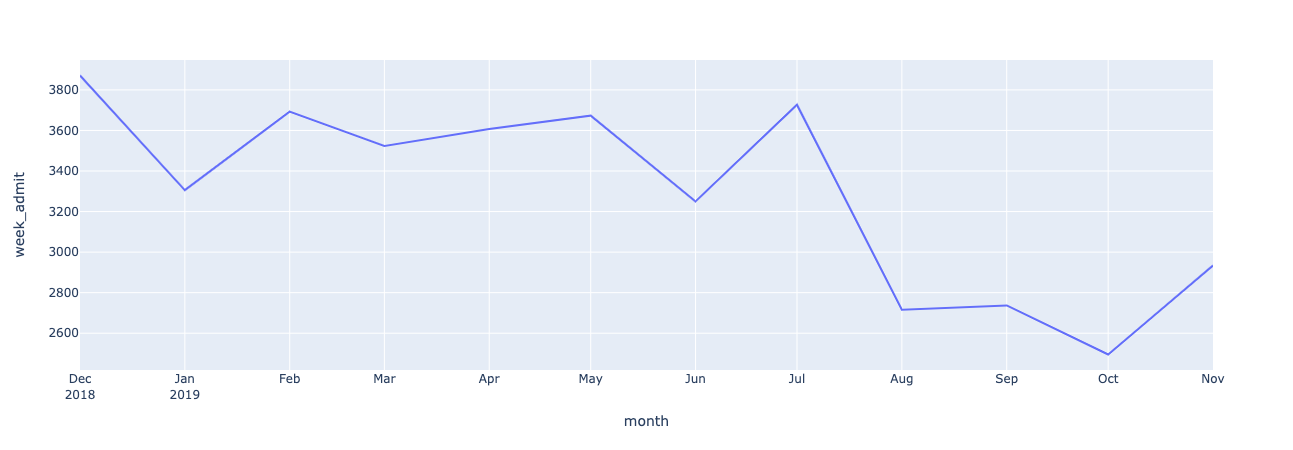

In [341]:
fig = px.line(data, 
              x = 'month', 
              y = "week_admit")

fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
)

fig.show()

## Where
---

Looking at where patient intake dropped

In [455]:
data2 = df_eda1.loc[df_eda1['week_admit'] == 1, ['week', 'county', 'onsite_hours']]

In [456]:
data2

,week,county,onsite_hours
0,2018-12-31,Brazos,1.70
1,2018-12-31,Brazos,1.70
2,2018-12-31,Brazos,1.70
3,2018-12-31,Brazos,1.70
4,2018-12-31,Brazos,1.70
...,...,...,...
139756,2019-11-25,Nueces,0.45
139757,2019-11-25,Nueces,0.45
139758,2019-11-25,Nueces,0.45
139761,2019-11-25,DeWitt,0.45


In [448]:
data2 = data2.groupby(by=['week', 'county']).agg(['sum', 'max', 'mean']).reset_index()

In [450]:
data2[data2['county'] == 'Harris']

month  county onsite_hours                
                                 sum   max      mean
65   2018-12-01  Harris       943.84  2.71  1.602445
227  2019-01-01  Harris       641.22  1.92  1.264734
394  2019-02-01  Harris       764.42  1.92  1.263504
566  2019-03-01  Harris       953.62  2.71  1.708996
732  2019-04-01  Harris       849.81  2.71  1.504088
903  2019-05-01  Harris       493.57  1.92  0.861379
1078 2019-06-01  Harris       849.25  2.71  1.722617
1238 2019-07-01  Harris       742.26  2.71  1.356965
1406 2019-08-01  Harris       235.92  1.92  0.430511
1570 2019-09-01  Harris       878.63  2.71  1.645375
1733 2019-10-01  Harris       608.23  1.92  1.267146
1901 2019-11-01  Harris       249.51  1.92  0.434686

In [413]:
data2 = data2.pivot_table(index=["month"], columns = 'county', values='onsite_hours')

In [414]:
data2.index.get_level_values(0)

DatetimeIndex(['2018-12-31', '2019-01-28', '2019-02-25', '2019-04-01',
               '2019-04-29', '2019-05-27', '2019-07-01', '2019-07-29',
               '2019-08-26', '2019-09-30', '2019-10-28', '2019-11-25'],
              dtype='datetime64[ns]', name='week', freq=None)

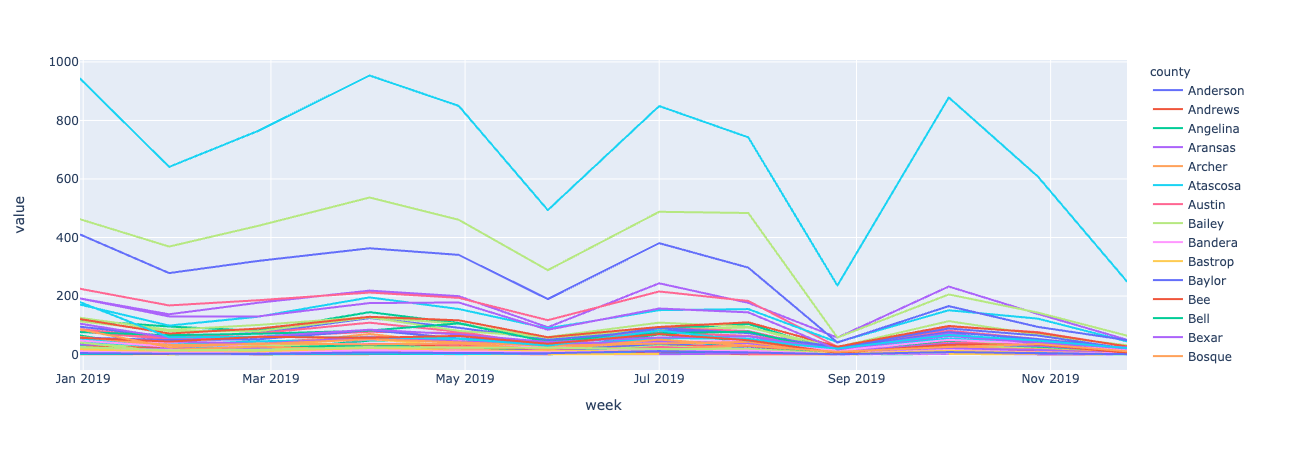

In [418]:
fig = px.line(data2, 
              x = data2.index.get_level_values(0), 
              y = data2.columns)

# fig.update_xaxes(
#     dtick="M1",
#     tickformat="%b\n%Y",
# )

fig.show()

In [400]:
data2

county,Anderson,Andrews,Angelina,Aransas,Archer,Atascosa,Austin,Bailey,Bandera,Bastrop,...,Wilbarger,Willacy,Williamson,Wilson,Winkler,Wise,Wood,Yoakum,Young,Zapata
month,,,,,,,,,,,,,,,,,,,,,
2018-12-01,5.0,NaN,22.0,2.0,NaN,10.0,2.0,1.0,1.0,12.0,...,1.0,3.0,54.0,3.0,1.0,16.0,5.0,NaN,3.0,NaN
2019-01-01,16.0,NaN,25.0,4.0,NaN,6.0,1.0,1.0,NaN,5.0,...,2.0,5.0,21.0,6.0,NaN,11.0,5.0,1.0,2.0,NaN
2019-02-01,10.0,NaN,17.0,3.0,NaN,9.0,2.0,1.0,1.0,10.0,...,2.0,7.0,33.0,3.0,NaN,13.0,3.0,2.0,2.0,NaN
2019-03-01,5.0,NaN,20.0,4.0,NaN,4.0,NaN,NaN,NaN,10.0,...,2.0,4.0,21.0,6.0,1.0,14.0,8.0,NaN,4.0,NaN
2019-04-01,12.0,NaN,17.0,5.0,NaN,7.0,2.0,2.0,1.0,10.0,...,NaN,2.0,29.0,2.0,NaN,14.0,6.0,NaN,3.0,NaN
2019-05-01,4.0,1.0,25.0,1.0,NaN,5.0,1.0,NaN,NaN,10.0,...,2.0,4.0,22.0,7.0,1.0,27.0,9.0,1.0,5.0,NaN
2019-06-01,6.0,NaN,40.0,1.0,NaN,3.0,NaN,1.0,3.0,8.0,...,1.0,1.0,33.0,1.0,NaN,11.0,6.0,1.0,6.0,NaN
2019-07-01,12.0,NaN,37.0,7.0,NaN,11.0,1.0,NaN,1.0,13.0,...,3.0,5.0,23.0,NaN,1.0,13.0,9.0,NaN,5.0,NaN
2019-08-01,6.0,NaN,16.0,3.0,NaN,4.0,1.0,1.0,2.0,13.0,...,1.0,1.0,26.0,5.0,1.0,1.0,1.0,NaN,2.0,NaN
